# Loading Data

In [ ]:
#!pip install numpy pandas seaborn matplotlib torch pydicom 

In [45]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation, rc
import seaborn as sns

import pydicom as dicom # dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import os
import time
import glob
import json
import collections
import torch
import torch.nn as nn

In [96]:
# read data
train_path = '/Users/jaesolshin/Library/CloudStorage/GoogleDrive-ysys143@gmail.com/내 드라이브/2024-2/Google ML Bootcamp2024/data/RSNA'

# 파일 구조 : study - series - instance
train  = pd.read_csv(train_path + '/train.csv') #study 전체의 질환별 심각도 레이블
label = pd.read_csv(train_path + '/train_label_coordinates.csv') #각 instance에서 병변의 유형과 좌표
train_desc  = pd.read_csv(train_path + '/train_series_descriptions.csv') #study 내 각 seires의 촬영정보
test_desc   = pd.read_csv(train_path + '/test_series_descriptions.csv') #study 내 각 series의 촬영정보
sub         = pd.read_csv(train_path + '/sample_submission.csv')

In [24]:
print("train shape :", train.shape)
print("train label shape :", label.shape)
print("train descriptions shape :", train_desc.shape)
print("test descriptions shape :", test_desc.shape)
print("submission shape :", sub.shape)

train shape : (1975, 26)
train label shape : (48692, 7)
train descriptions shape : (6294, 3)
test descriptions shape : (3, 3)
submission shape : (25, 4)


In [83]:
label.head()

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602


In [26]:
# study_id, series_id를 바탕으로 instance 이미지 파일에 접근할 수 있도록 경로를 생성해주는 함수
# 이미지 파일이 있는 폴더 경로를 입력으로 받고, 해당 경로에서 df의 study_id, series_id를 하위경로명으로 가지는 폴더로 접근.
# 각 시리즈별 폴더에 속한 파일명을 조회한 뒤, 이를 붙여 전체 파일경로를 만들어 image_paths에 저장한 뒤 반환.

def generate_image_paths(df, data_dir):
    image_paths = [] #이미지 파일 경로를 저장할 리스트
    for study_id, series_id in zip(df['study_id'], df['series_id']): #인수로 받은 데이터 프레임의 study_id, series_id열을 tuple로 묶어서 조회
        study_dir = os.path.join(data_dir, str(study_id)) #인수로 받은 경로에 study_id를 폴더명으로 가지는 하위경로를 study_dir에 저장
        series_dir = os.path.join(study_dir, str(series_id)) #study_dir에서 series_id를 폴더명으로 가지는 하위경로를 series_dir에 저장
        images = os.listdir(series_dir) #series_dir의 파일목록 조회
        image_paths.extend([os.path.join(series_dir, img) for img in images]) #파일목록을 series_dir에 추가하여 image_paths에 저장
    return image_paths

#train_desc의 study_id, series_id열을 조회하여, /train_images 폴더에서 해당 스터디-시리즈에 포함된 이미지 경로를 추출
train_image_paths = generate_image_paths(train_desc, f'{train_path}/train_images') 
#test_desc의 study_id, series_id열을 조회하여, /test_images 폴더에서 해당 스터디-시리즈에 포함된 이미지 경로를 추출
test_image_paths = generate_image_paths(test_desc, f'{train_path}/test_images')

In [32]:
# 경로가 잘 생성되었음을 확인
train_image_paths[:5]

['/Users/jaesolshin/Library/CloudStorage/GoogleDrive-ysys143@gmail.com/내 드라이브/2024-2/Google ML Bootcamp2024/data/RSNA//train_images/4003253/702807833/15.dcm',
 '/Users/jaesolshin/Library/CloudStorage/GoogleDrive-ysys143@gmail.com/내 드라이브/2024-2/Google ML Bootcamp2024/data/RSNA//train_images/4003253/702807833/14.dcm',
 '/Users/jaesolshin/Library/CloudStorage/GoogleDrive-ysys143@gmail.com/내 드라이브/2024-2/Google ML Bootcamp2024/data/RSNA//train_images/4003253/702807833/10.dcm',
 '/Users/jaesolshin/Library/CloudStorage/GoogleDrive-ysys143@gmail.com/내 드라이브/2024-2/Google ML Bootcamp2024/data/RSNA//train_images/4003253/702807833/11.dcm',
 '/Users/jaesolshin/Library/CloudStorage/GoogleDrive-ysys143@gmail.com/내 드라이브/2024-2/Google ML Bootcamp2024/data/RSNA//train_images/4003253/702807833/13.dcm']

In [88]:
print("n of study \t:", len(train))
print("n of series \t:", len(train_desc))
print("n of images \t:", len(train_image_paths))
print("n of labels \t:", len(label)) 

print('\n모든 image(instance)에 label이 부여된 것은 아님')

n of study 	: 1975
n of series 	: 6294
n of images 	: 147218
n of labels 	: 48692

모든 image(instance)에 label이 부여된 것은 아님


(320, 320)


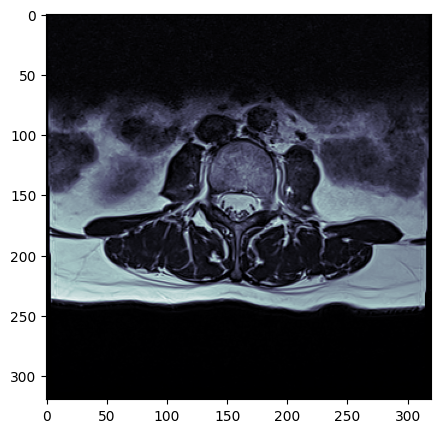

In [91]:
# DICOM 이미지 한장을 열어보기
# DICOM : 의료 이미징 정보를 저장하고 전송하기 위한 표준 형식
# pydicom 라이브러리로 읽어들이고, matplotlib을 통해 화면에 나타낼 수 있음
plt.figure(figsize=(15,5)) 
ds = dicom.dcmread(train_image_paths[30]) #30번째 이미지
plt.imshow(ds.pixel_array, cmap = plt.cm.bone)
print(ds.pixel_array.shape) #(320,320) 해상도의 이미지

In [74]:
#DICOM 파일에 포함된 메타데이터
ds.dir


<bound method Dataset.dir of Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Enhanced MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 4003253.1.16
(0002, 0010) Transfer Syntax UID                 UI: RLE Lossless
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.4.2'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 4003253.1.16
(0008, 0023) Content Date                        DA: '20240503'
(0008, 0033) Content Time                        TM: '223717.117369'
(0008, 103e) Series Description                  LO: 'T2'
(0010, 0020) Patient ID                          LO: '4003253'
(0018, 0050) Slice Thickness                     DS: '4.0'
(0018, 0088) Spacing Between Slices              DS: '4.4'
(0018, 5100) Pati

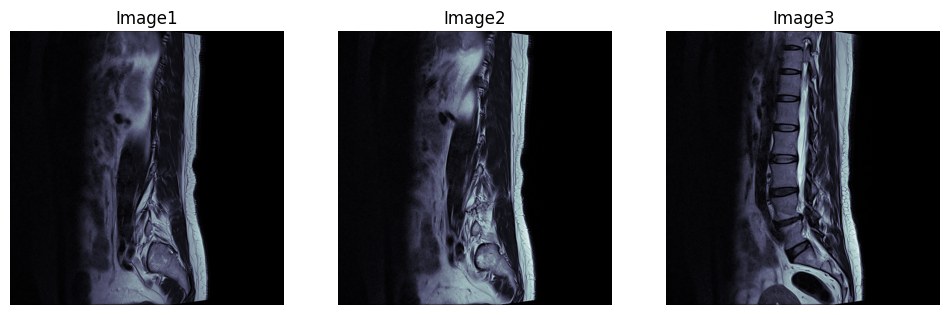

In [127]:
# DICOME 이미지를 열고 표시하기 위한 함수
def display_dicom_images(image_paths, n):
    plt.figure(figsize=(12,4)) #이미지 크기
    for i, path in enumerate(image_paths[:n]): #n번째 이미지까지 조회 - enumerate()은 iterable 객체를 받아 인덱스와 요소를 함께 반환
        ds = dicom.dcmread(path) 
        plt.subplot(1, 3, i+1)
        plt.imshow(ds.pixel_array, cmap = plt.cm.bone)
        plt.title(f"Image{i+1}") #
        plt.axis('off')
    plt.show()

# train 이미지의 첫번째 사진 3개 출력
display_dicom_images(train_image_paths,3)

In [168]:
train_desc[train_desc['study_id'] == 10728036] # 같은 방향 사진이 2장 있는 경우도 있음

,study_id,series_id,series_description
12,10728036,142859125,Axial T2
13,10728036,2073726394,Axial T2
14,10728036,2399638375,Sagittal T1
15,10728036,3491739931,Sagittal T2/STIR


In [170]:
label

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602
...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,Left Neural Foraminal Narrowing,L1/L2,219.465940,97.831063
48688,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L2/L3,205.340599,140.207084
48689,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L3/L4,202.724796,181.013624
48690,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L4/L5,202.933333,219.733333


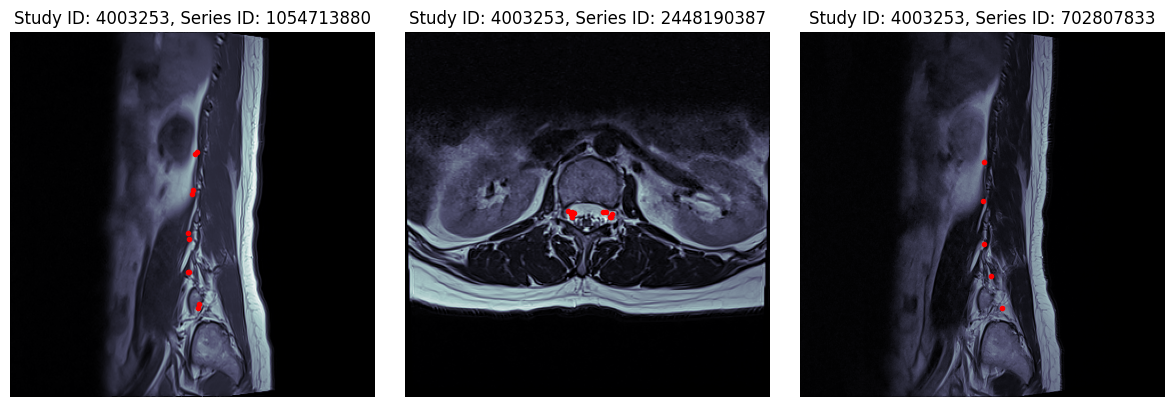

In [188]:
#이미지를 label에 저장된 병변의 좌표와 함께 표시

#이미지 경로와 레이블을 받아 출력하는 함수
def display_dicom_with_coordinates(image_paths, label_df, exact_image):
    
    # len(image_paths) 개의 서브플롯을 가로로 나란히 생성하고, 각각의 서브플롯에 DICOM 이미지를 표시
    fig, axs = plt.subplots(1, len(image_paths), figsize=(12,4)) #fig는 전체그림, axs는 개별 서브플롯

    for idx, path in enumerate(image_paths):

        # 이미지 경로로부터 다시 study_id, series_id 추출
        study_id = int(path.split('/')[-3]) #study_id 추출
        series_id = int(path.split('/')[-2]) #series_id 추출

        # DICOM 이미지 오픈
        ds = dicom.dcmread(path)

        # DICOM 이미지 표시
        axs[idx].imshow(ds.pixel_array, cmap=plt.cm.bone)
        axs[idx].set_title(f'Study ID: {study_id}, Series ID: {series_id}')
        axs[idx].axis('off')

        # label 데이터프레임에서 이미지와 동일한 study_id, series_id를 가지는 행을 추출 
        # 같은 시리즈의 병변 좌표를 모두 출력(exact_image == False)
        if exact_image == False:
            filtered_labels = label_df[(label_df['study_id'] == study_id) & 
                                       (label_df['series_id'] == series_id)]
        # 이미지와 동일한 instance_number 조건까지 추가하면 정확히 해당 이미지의 label만 출력(exact_image == True)
        elif exact_image == True:
            instance_number = ds.InstanceNumber # DICOM 파일에서 instance_number 추출
            filtered_labels = label_df[(label_df['study_id'] == study_id) & 
                                       (label_df['series_id'] == series_id) &
                                       (label_df['instance_number'] == instance_number)]
        else:
            raise ValueError('Invalid exact_image value')

        # 지정된 조건에 따라 filtered_labels에 저장된 행들을 조회하며 병변의 좌표 출력
        # exact_image == False으로 여러 행이 존재할 경우, 여러 마커를 출력
        for _, row in filtered_labels.iterrows(): 
            axs[idx].plot(row['x'], row['y'], 'ro', markersize=3)
        
    plt.tight_layout()
    plt.show()

# display_dicom_with_coordinates(train_image_paths[0:3], label) - 정상작동함을 확인

# 폴더 경로로부터 인스턴스 파일들을 불러오는 함수
def load_dicom_files(path_to_folder):
    # path_to_folder에 속한 파일들을 불러오되, 확장자가 '.dcm'으로 되어있는지 확인
    files = [os.path.join(path_to_folder, f) for f in os.listdir(path_to_folder) if f.endswith('.dcm')]
    # basename()으로 전체 파일경로에서 파일명을 추출하고, splitext()으로 확장자를 제거한 뒤, '-'를 기준으로 나누어 인스턴스 번호를 추출하고, 이를 기준으로 정렬
    files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('-')[-1]))
    return files

# DICOM 이미지를 병변 좌표와 함께 표시
study_id = train['study_id'][0] # 예시로 첫번째 study_id를 사용해보았음
study_folder = f'{train_path}/train_images/{study_id}' # study_folder 경로를 만들고

image_paths = [] # image_paths 초기화
for series_folder in os.listdir(study_folder): # study_folder 내 series_folder들에 대해
    series_folder_path = os.path.join(study_folder, series_folder) # series_folder 경로를 따오고
    dicom_files = load_dicom_files(series_folder_path) # series_folder 경로로부터 인스턴스 파일들을 경로들을 불러온 뒤
    if dicom_files:
        image_paths.append(dicom_files[0]) # 시리즈의 첫 인스턴스 파일 경로를 image_paths에 저장

display_dicom_with_coordinates(image_paths, label, False) # image_paths에 저장된 경로의 이미지를 label과 함께 출력